## Does increasing the amount of government spending on its citizens decreases the amount of the income inequality?

INCREASING THE PERCENTAGE OF SHARING DECREASES INCOME INEQUALITY

How to measure inequality

### Gini index
Gini index is income distribution across population with a range from 0-1. A higher value means higher the inequality.

### IPF
<strong>Inequality Possibility Frontier </strong> if the country has sufficient economical situation and that there can be a situation for its people to become inequal in its distribitoun.  


- Market household income is defined as the sum of labor income (paid employment and self-employment income) and capital income.

- Disposable household income is the sum of labor income (paid employment and self-employment income), capital income, transfer income—social security transfers (work-related insurance transfers, universal benefits, and assistance benefits) and private transfers—, minus income taxes and social security contributions.


### What does Goverment spending on its citizens mean?

 Public spending also shows that governments around the world often rely on the private sector to produce and manage goods and services. And public-private partnerships (PPP), in particular, have become an increasingly popular mechanism for governments to finance, design, build and operate infrastructure projects
The steep growth of social spending in the second half of the 20th century was largely driven by the expansion of public funding for healthcare and education. 


### Objectives
Does increasing % of Countries Social Spending have a statistically significant effect on income inequality of the country? If so, at how effective it is?


Which tests to run?

- An Independent Samples t-test compares the means for two groups.
- A Paired sample t-test compares means from the same group at different times (say, one year apart).
- A One sample t-test tests the mean of a single group against a known mean.

#### Hypothesis
H0 = Government spending on its citizens does not have a effect on income equality?
HA = Govenrment spending on its citizens decreases the income equality?


In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro

%matplotlib inline

## Data Cleaning


In [221]:
gd = pd.read_csv('../dataset/social-spending-oecd-longrun.csv')
ineq = pd.read_csv('../dataset/inequality-before-and-after-taxes-and-transfers-Thewissen-et-al-data.csv')

print("Shape of social spending dataset is {} and the shape of inequality dataset is {}".format(gd.shape,ineq.shape))
print("Social spending dataset years are {}-{} and inequality dataset years are {}-{}".format(gd.Year.min(),gd.Year.max(),ineq.Year.min(),ineq.Year.max()))

display(gd.head())
display(ineq.head())

Shape of social spending dataset is (817, 4) and the shape of inequality dataset is (180, 5)
Social spending dataset years are 1880-2016 and inequality dataset years are 1978-2013


,Entity,Code,Year,Social Expenditure %GDP - (OWID extrapolated series) (%)
0,Australia,AUS,1880,0
1,Australia,AUS,1890,0
2,Australia,AUS,1900,0
3,Australia,AUS,1910,1.12
4,Australia,AUS,1920,1.66


,Entity,Code,Year,Market Income,Disposable Income
0,Australia,AUS,1981,0.405,0.282
1,Australia,AUS,1985,0.440,0.293
2,Australia,AUS,1989,0.440,0.304
3,Australia,AUS,1995,0.483,0.311
4,Australia,AUS,2001,0.498,0.320


In [329]:
def nearestYear(df1,df2):
    # Match the year and the country with inequality dataset and than match the closest year with that countries yeardates
    # Match a year once as well
    # Get years of a given country in ineqality dataset
    new = df1
    countries = list(df1.Entity.unique())
    
    for country in countries:
        
        year_list = list(set(df2[df2.Entity == country].Year))
        for index, row in df1[df1.Entity == country].iterrows():
            # find the closest year
            year = row['Year']
            if len(year_list) > 0:
                closest = min(year_list, key=lambda x:abs(x-year))
                # Remove the matched year so it macthes only once
                year_list.remove(closest)
                new.loc[index,'RoundYear'] = closest
            else:
                new.loc[index,'RoundYear'] = None
           
    return new


In [330]:
# take years after 1977 which is the years where inequality dataset starts
gd = gd[gd.Year >1977]
# Create new data set where we match the year of gdp to inequality of years
new = nearestYear(gd,ineq)

In [376]:
# Merge two dataframe on years it matches and country name
new.dropna(inplace=True)
df = pd.merge(ineq[['Entity','Year','Market Income','Disposable Income']], 
              new[['Entity','RoundYear','Social Expenditure %GDP - (OWID extrapolated series) (%)']],  
              how='inner', left_on=['Entity','Year'], right_on = ['Entity','RoundYear'])
# Rename Social Expediture percentage column
df.rename(columns={'Social Expenditure %GDP - (OWID extrapolated series) (%)': 'Percent_GDP','Disposable Income':'Disposable_Income'},inplace=True)
# Delete row with  string '..' Convert object type to float
df = df[df.Percent_GDP != '..']
df.Percent_GDP = df.Percent_GDP.astype(float)
df = df[df.Percent_GDP != 0]
df.dropna(inplace = True)
mean = df.Percent_GDP.mean()
print('the average of percentage spend by countries is {}, the shape of the dataframe is {}'.format(mean,df.shape))
# Countries who spend more of their shares than 21 percent
df['MoreThanMean'] = df.Percent_GDP.apply(lambda x: 0 if x < mean else 1)
# Gini index indicates if it is higher than there is higher inequality
print('The data starts from {} and ends in year {}'.format(df.Year.min(),df.Year.max()))
df.head()

the average of percentage spend by countries is 19.21329161654386, the shape of the dataframe is (171, 6)
The data starts from 1978 and ends in year 2013


,Entity,Year,Market Income,Disposable_Income,RoundYear,Percent_GDP,MoreThanMean
0,Australia,1981,0.405,0.282,1981.0,10.637890,0
1,Australia,1985,0.440,0.293,1985.0,10.296414,0
2,Australia,1989,0.440,0.304,1989.0,10.268000,0
3,Australia,1995,0.483,0.311,1995.0,12.088000,0
4,Australia,2001,0.498,0.320,2001.0,13.131000,0


In [386]:
df.to_csv('../dataset/gdp_ineq.csv',index=False)

In [377]:
more_df = df[df.MoreThanMean == 1]
less_df = df[df.MoreThanMean == 0]

In [378]:
stat, p = stats.normaltest(less_df['Disposable_Income'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=3.943, p=0.139
Sample looks Gaussian (fail to reject H0)


/Users/kaanbursa/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


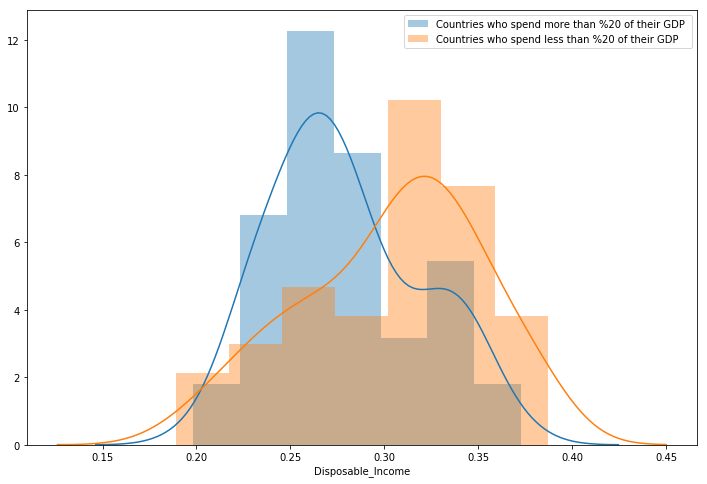

In [379]:
plt.figure(figsize=(12,8))
sns.distplot(more_df['Disposable_Income'],label='Countries who spend more than %20 of their GDP ')
sns.distplot(less_df['Disposable_Income'],label='Countries who spend less than %20 of their GDP')
plt.legend()

Text(0.5, 1.0, 'Disposable Income Q-Q Plot')

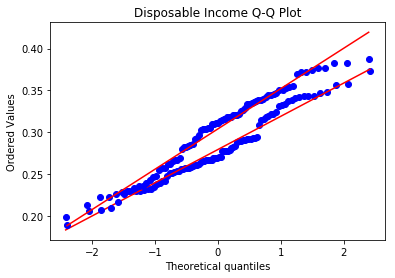

In [388]:
# We want to check if data is normally distributed with QQ plot
stats.probplot(more_df['Disposable_Income'], plot= plt)
stats.probplot(less_df['Disposable_Income'], plot= plt)
plt.title('Disposable Income Q-Q Plot')

### Assumptions for T-test

1. The first assumption made regarding t-tests concerns the scale of measurement. The assumption for a t-test is that the scale of measurement applied to the data collected follows a continuous or ordinal scale, such as the scores for an IQ test.
2. The second assumption made is that of a simple random sample, that the data is collected from a representative, randomly selected portion of the total population.
3. The third assumption is the data, when plotted, results in a normal distribution, bell-shaped distribution curve. When a normal distribution is assumed, one can specify a level of probability (alpha level, level of significance, p) as a criterion for acceptance. In most cases, a 5% value can be assumed.
4. The fourth assumption is a reasonably large sample size is used. A larger sample size means the distribution of results should approach a normal bell-shaped curve.
5. The final assumption is homogeneity of variance. Homogeneous, or equal, variance exists when the standard deviations of samples are approximately equal.

In [343]:
# Import stats model for power analysis
from statsmodels.stats.power import TTestIndPower

In [381]:
# Cohens d test for measuring effect size in t-test
alpha = 0.05
#statspower = 0.8
cohend = abs(more_df['Disposable_Income'].mean() - less_df['Disposable_Income'].mean())


Cohens distance for the populations is 0.0247 which is the effect size. Sample size is 88
and our significane level is (alpha) 0.05 and our statistical power is 0.8 
      


In [367]:
analysis = TTestIndPower()
power = analysis.solve_power(cohend, power=None, nobs1=len(more_df), ratio=1.0, alpha=alpha)

In [387]:
print("""Cohens distance for the populations is {} which is the effect size. Sample size is {}
and our significane level is (alpha) {} and our statistical power is {} 
      """.format(round(cohend,4),len(more_df),alpha,power))

Cohens distance for the populations is 0.0247 which is the effect size. Sample size is 88
and our significane level is (alpha) 0.05 and our statistical power is 0.05303715252335816 
      


In [382]:
# Run two tailed sided welchs-t-test so we can see if the effect is positive or negative
results = stats.ttest_ind(more_df['Disposable_Income'], less_df['Disposable_Income'],equal_var = False)

In [370]:
# Negative t-value means higher the percentage share to people less income inequality and lower gini index
alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of {} is greater than mean of {}".format('Male','Female'))
else:
    print("accept null hypothesis with t-value of {} and p-value of {}".format(results[0],results[1]))

accept null hypothesis with t-value of -3.6422852388421982 and p-value of 0.00036488703355117637


WE can say that t-value of apprx -4 is that 

In [383]:
stats.f_oneway(more_df['Disposable_Income'], less_df['Disposable_Income'])

F_onewayResult(statistic=13.411733268251668, pvalue=0.00033420308938501885)

Even though our p-value is low for this test we cannot reject the null hypothesis because of our really small power value

In [372]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [384]:
results = ols('Disposable_Income ~ Percent_GDP', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Disposable_Income   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     13.90
Date:                Thu, 02 Jan 2020   Prob (F-statistic):           0.000263
Time:                        14:37:49   Log-Likelihood:                 292.69
No. Observations:                 171   AIC:                            -581.4
Df Residuals:                     169   BIC:                            -575.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3448      0.015     23.323      0.000       0.316       0.374
Percent_GDP    -0.0028      0.001     -3.728      0.000      -0.004      -0.001
==============================================================================
Omnibus:                        5.036   Durbin-Watson:                   0.633
Prob(Omnibus):                  0.081   Jarque-Bera (JB):                2.832
Skew:                          -0.029   Prob(JB):                        0.243
Kurtosis:                       2.372   Cond. No.                         87.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Notes

The power of a hypothesis test is the probability of rejecting the null hypothesis H0 when the alternative hypothesis HA is the hypothesis that is true.

We wanted to compare two different sample's and wanted to see the effect if it was negative or positive. So we ran <strong>Welch's T-test </strong> since the sample populations where not identical. T-test gave us the result that the p-value is lower in our two sample's however when we did power analysis our our power parameter was really low meaning the we should not believe our alternative hypothesis easily with out sample size. 